  Using cached fsspec-2025.3.2-py3-none-any.whl.metadata (11 kB)


Batches:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 1, Loss: 0.0997
Epoch 2, Loss: 0.0597
Epoch 3, Loss: 0.0431
Silhouette Score: 0.07843419
Davies-Bouldin Index: 2.998826391874378
Calinski-Harabasz Index: 75.69212


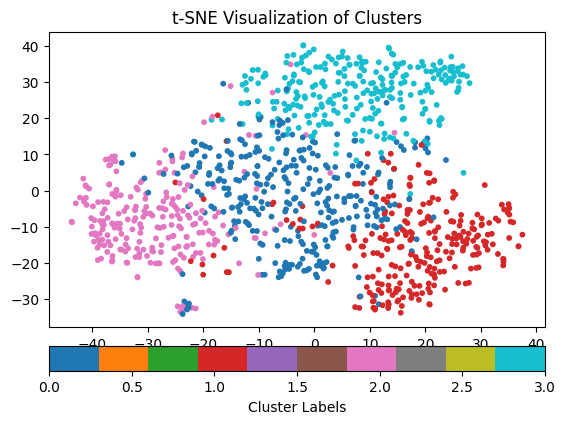

In [ ]:
# Install and import necessary libraries
!pip install -U sentence-transformers datasets pandas fsspec

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.metrics import calinski_harabasz_score
import pandas as pd
import re

# Load AG News dataset from Hugging Face
url = "hf://datasets/Zhouhc/attack-agnews/agnews_train.csv"
df = pd.read_csv(url)

df_sample = df.sample(frac=0.01, random_state=241).reset_index(drop=True)


def clean_text(text):
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"[^A-Za-z0-9\s.,!?]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text.lower()

df_sample["clean_text"] = df_sample["text"].apply(clean_text)

texts = df_sample["clean_text"].tolist()



model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode(texts, show_progress_bar=True)

# Define encoder network
class Encoder(nn.Module):
    def __init__(self, input_size=384, hidden_size=128, embedding_size=64):
        super(Encoder, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, embedding_size)
        )

    def forward(self, x):
        return self.net(x)

# Convert embeddings to tensors
embeddings_tensor = torch.tensor(embeddings, dtype=torch.float32)
dataset = TensorDataset(embeddings_tensor)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Encoder().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()  # Autoencoder-style: input = target

# Training
for epoch in range(3):
    model.train()
    total_loss = 0
    for batch in loader:
        x = batch[0].to(device)
        optimizer.zero_grad()
        output = model(x)
        loss = loss_fn(output, x[:, :output.shape[1]])
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch + 1}, Loss: {total_loss:.4f}")

# Extract latent features
model.eval()
with torch.no_grad():
    latent = model(embeddings_tensor.to(device)).cpu().numpy()

# Clustering
kmeans = KMeans(n_clusters=4, random_state=241)
cluster_labels = kmeans.fit_predict(latent)
ch_score = calinski_harabasz_score(latent, cluster_labels)
# Evaluate clustering quality
print("Silhouette Score:", silhouette_score(latent, cluster_labels))
print("Davies-Bouldin Index:", davies_bouldin_score(latent, cluster_labels))
print("Calinski-Harabasz Index:", ch_score)


# t-SNE visualization
tsne = TSNE(n_components=2, random_state=241)
proj = tsne.fit_transform(latent)
scatter = plt.scatter(proj[:, 0], proj[:, 1], c=cluster_labels, cmap='tab10', s=10)
plt.title("t-SNE Visualization of Clusters")
cbar = plt.colorbar(scatter, orientation='horizontal', pad=0.05)
cbar.set_label('Cluster Labels')
plt.show()
